## Goal: to manipulate raw crime data to take a look at violent crime between 2016-2018
##### Assumptions: There is more than 1 person involved in a crime, sometimes more than 1 suspect. We will only be looking at those who have been arrested
##### Intended Result: A dataframe with one line per offence report, as well as other intermediate dataframes

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns=200
pd.options.display.max_rows=1000 

%matplotlib inline 

In [2]:
# try using glob later 
# https://stackoverflow.com/questions/56990908/read-and-save-multiple-csv-files-from-a-for-loop
data_paths = [['data_16','KCPD_Crime_Data_2016.csv'],
              ['data_17','KCPD_Crime_Data_2017.csv'],
              ['data_18','KCPD_Crime_Data_2018.csv']]
    
df_dct = {name:pd.read_csv(str('raw-crime-data/')+filepath,
                      dtype = {"Zip Code":object, 
                               'Report_No':object, 
                              'Report_No':object,
                              'Offense':object}) for name, filepath in data_paths}
df = pd.concat([pd.concat(df_dct, sort = False)]).reset_index()
df.columns = df.columns.str.replace(' ', '_')
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace('/', '_')
df.columns = df.columns.str.replace('-', '_')
df,df = df.drop(columns = ['level_1']), df.rename(columns = {'level_0' : 'source_df'})

In [3]:
# check lengths
for key in df_dct:
    print(str(key)+":",len(df_dct[key]))
    
print('length of all df: ', len(df))

data_16: 127877
data_17: 132139
data_18: 128938
length of all df:  388954


In [4]:
# droping certian data
print('droping {} rows where race = *'.format(len(df[df.race == '*'])))
df = df[df.race != '*']
print(len(df))
print('dropping {} rows because their age greater than 100 and that seems unlikely'.format(len(df[df.age >= 100])))
df = df[df.age <= 100]

droping 3 rows where race = *
388951
dropping 88 rows because their age greater than 100 and that seems unlikely


###### I need to clean some of these descriptions up, they are messy

In [5]:
descriptions_ids = pd.DataFrame(df.description.unique(), columns=['description'])
descriptions_ids.sort_values('description')

def replaceDescriptions(listy,arg):
    return df.description.replace([listy],arg, inplace = True)

things = [
        [['AGG ASSAULT','agg assault','Aggravated Assault (','Agg Assault','Agg Assault - Drive-'],'Aggravated Assault'],
         [['Agg Assault - Domest','Agg Assault Dome','agg dv assault'],'Aggravated Assault - Domestic'],
         [['Attempt Suicide by C','Attempt Suicide by D','Attempt Suicide by G',
                                     'Attempt Suicide by H','Attempt Suicide by J','Attempt Suicide by O',
                                     'Attempt Suicide by P','Attempt Suicide by S'], 'Attempt Suicide'],
         [['Auto Theft Outside S','auto theft'],'Auto Theft'],
         ['Bomb Threat/Intimida', 'Bomb Threat'],
          ['Bombing (other than','Bombing'],
          ['Burg Res Occ','Burglary - Residence'],
          ['Burglary - Non Resid', 'Business Robbery'],
          ['Casualty (includes a','Casualty'],
          ['Driving Under Influe','DUI'],
          ['False Information to','False Information'],
          ['HOMICIDE/Non Neglige','Homocide'],
          ['Hit and Run of a Per','Hit and Run - Person'],
          ['Human Trafficking/Co', 'Human Trafficking'],
          [['NON AGG ASSAULT DV','Non Aggravated Assau','non agg assault','non aggravated assau'],'Non Aggravated Assault'],
          ['Promoting Prostituti','Promoting Prostitution'],
          ['Prostitution/Solicit','Prostitution/Soliciting'],
          [['Sex Off Follow/Entic','Sex Off Fondle - mol','Sex Off Incest','Sex Off Indecent Con',
           'Sex Off Misconduct','Sex Offense -others'],'Sexual Offense'],
          ['Sexual Assault with','Sexual Assault'],
          ['Stealing Auto Parts/','Stealing Auto Parts'],
          [['Stealing from uildi','Stealing Acc','STEAL TFA'],'Stealing All Other'],
          ['Stealing Coin Operat','Stealing Coin'],
          ['Stealing Purse Snatc','Stealing Purse'],
          [['Suicide by Other Mea','Suicide - Domestic V'],'Suicide by Other Means'],
          ['TRASH DUMPING','Dumping (littering)'],
          ['Non Agg Assault Dome','Non Aggravated Assault - Domestic'],
          ['Sex Off Indecent Exp','Indecent Exposure'],
          [['trespassing','TRESPASS'],'Trespassing'],
          ['URINATE IN PUBLIC', 'Public Urination'],
          ['Violation Ex Parte O', 'Violation Ex Parte Order'],
          ['black mail', 'Black Mail'],
          ['broken window','Broken Window'],
          ['disorderly conduct','Disorderly Conduct'],
          ['forgery','Forgery'],
          ['kidnapping','Kidnapping/Abduction'],
          ['property damage','Property Damage'],
          [['robbery','stealing','stealing from buildi','Stealing from Buildi'], 'Burglary'],
          ['misc violation','Misc Violation'],
          ['misc off','Misc Offense'],
          ['strong armed robbery','Strong Arm Robbery'],
          ['Stolen Property OFFE','Stolen Property'],
          ['Accidental Drug Over','Accidental Drug Overdose']
         ]

bad_cols = ['`','s','1','4','5']

for x,y in things:
    replaceDescriptions(x,y)

df = df[df.description.isin(bad_cols) == False]


I need to find some sort of way to make a unique ID for each charge within a police report. First I need to fix up the names some

In [6]:
descriptions_ids = pd.DataFrame(df.description.unique(), columns=['description'])

while True:
    descriptions_ids['charge_id'] = [np.random.randint(1,999) for x in descriptions_ids.description]
    if descriptions_ids.charge_id.nunique() == len(descriptions_ids.description):
        break 

print('unique descriptions',descriptions_ids.description.nunique(),'unique ids',descriptions_ids.charge_id.nunique())

# join to df 
df = pd.merge(df,descriptions_ids, on = 'description')

# create the unique identifier
df['crime_id'] = df.report_no.map(str) +"_"+ df.charge_id.map(str)

unique descriptions 101 unique ids 101


In [7]:
df.to_csv('crime_data_16_18_raw.csv')

### Create an aggregated datatable

###### Look at the distribution of ages to inform how age buckets are created later on. 

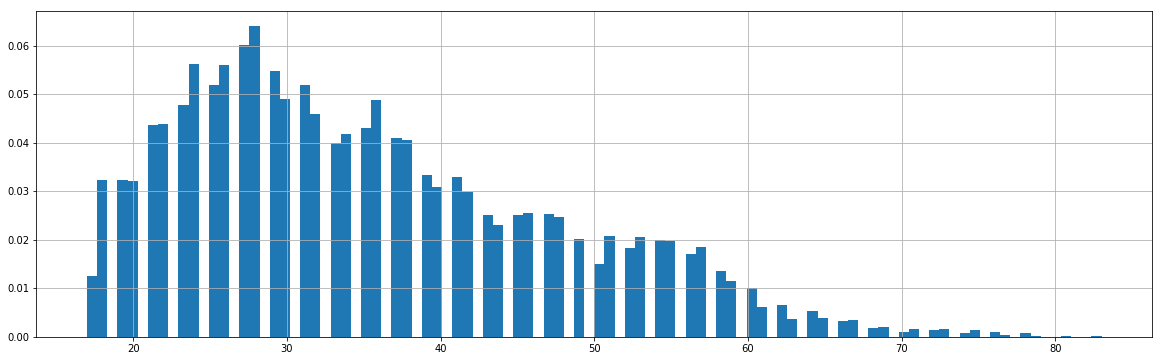

In [8]:
violent_crimes = ['Homocide','Non Aggravated Assault','Aggravated Assault','Non Aggravated Assault - Domestic',
                 ' Aggravated Assault - Domestic','Armed Robbery','Strong Arm Robbery']

# thinking behind age buckets 
df[(df.age<= 100) & 
   (df.description.isin(violent_crimes)== True) & 
   (df.involvement.isin(['ARR']) == True)].age.hist(bins=100,figsize=[20,6], 
                                                          density = True)

It appears that the distribution of arrests relating to violent crime is very right skewed

In [9]:
df_agg = df

def involmentFlag(role):
    x = np.where(df_agg.involvement == role,1,0)
    return x 

def raceFlag(race):
    x = np.where(df.race == race,1,0)
    return x

def ageFlag(min_age,max_age):
    x = np.where((df.age >= min_age) & (df.age <= max_age), 1,0)
    return x 
    
# involment
df_agg['arr_flag'] = involmentFlag('ARR')
df_agg['vic_flag'] = involmentFlag('VIC')
df_agg['sus_flag'] = involmentFlag('SUS')
# gender 
df_agg['male_flag'] = np.where(df.sex == "M",1,0)
df_agg['female_flag'] = np.where(df.sex == "F",1,0)
# race 
race_cols = [['black_race_flag', 'B'], ['nan_race_flag','nan'],['unknown_race_flag', 'U'],['white_race_flag','W'],
            ['asian_race_flag','A'],['indian_race_flag', 'I'], ['pacific_race_flag', 'P']]

for name,race in race_cols:
    df_agg[name] = raceFlag(race)
    
# gun
df_agg.firearm_used_flag = np.where(df_agg.firearm_used_flag == 'Y',1,0)

# dv
df_agg.dvflag = np.where(df_agg.dvflag == 'Y',1,0)

# age
age_cols = [['age_minor', 16,17], ['age_18_24',18,24],['age_25_29',25,29], ['age_30_34',30,34],['age_35_39',35,39],
           ['age_40_44',40,44],['age_45_49',45,49],['age_50_plus',50,100]]

for name,age1,age2 in age_cols:
    df_agg[name] = ageFlag(age1,age2)
    


###### get victims for later

In [10]:
agg_vic = df_agg[df_agg.vic_flag == 1]
agg_vic = agg_vic[['crime_id','vic_flag','male_flag','female_flag']]

agg_vic.rename(columns = {'male_flag':'male_vic', 
                         'female_flag':'male_vic',
                         'vic_flag':'total_vic'}, 
              inplace = True)
agg_vic = agg_vic.groupby('crime_id').sum()

In [11]:
df_grouped = df_agg[df_agg.involvement == 'ARR']
df_grouped = df_grouped[['crime_id', 'from_date','description','zip_code',"charge_id",'dvflag', 'firearm_used_flag',
                         'arr_flag','vic_flag', 'sus_flag', 'male_flag', 'female_flag', 'black_race_flag','nan_race_flag', 
                         'unknown_race_flag', 'white_race_flag','asian_race_flag', 'indian_race_flag', 'pacific_race_flag', 
                         'age_minor','age_18_24', 'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44','age_45_49', 
                         'age_50_plus']]

df_grouped = df_grouped.groupby(['crime_id','from_date','description','zip_code',"charge_id",]).sum()

Join in victim info

In [12]:
df_grouped.reset_index(inplace = True)

df_final = pd.merge(df_grouped,agg_vic, on = 'crime_id', how = 'left')

df_final.fillna(0,inplace = True)
df_final.rename(columns = {'arr_flag':'arr',
                          'male_flag':'male_arr',
                          'female_flag':'female_arr',
                          },inplace = True)
df_final.drop(columns = ['vic_flag','sus_flag'], inplace = True)

##### Check out final product and export

In [13]:
df_final.head()

,crime_id,from_date,description,zip_code,charge_id,dvflag,firearm_used_flag,arr,male_arr,female_arr,black_race_flag,nan_race_flag,unknown_race_flag,white_race_flag,asian_race_flag,indian_race_flag,pacific_race_flag,age_minor,age_18_24,age_25_29,age_30_34,age_35_39,age_40_44,age_45_49,age_50_plus,total_vic,male_vic,male_vic
0,100034831_134,10/18/2016,Stolen Property,64130,134,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0
1,130056370_946,7/3/2016,Possession/Sale/Dist,64133,946,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0
2,140071459_134,3/26/2016,Stolen Property,64130,134,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,1.0,0.0
3,150064182_946,08/26/2018,Possession/Sale/Dist,64157,946,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0
4,150082191_946,10/18/2017,Possession/Sale/Dist,64105,946,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0


In [14]:
df_final.to_csv('clean_crime_data.csv', index = False)